In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import optuna
from tqdm.notebook import tqdm
import torchvision

# REGRESSION

## FUNCTIONS

In [2]:
class RegressionDataset(Dataset):

    def __init__(self, df, transform=None):
        
        self.transform = transform
        # Read the file and store the content in a pandas DataFrame
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sample = (row.input, row.label)
        if self.transform:
            sample = self.transform(sample)
        return sample
    
class ToTensor(object):
    def __call__(self, sample):
        x, y = sample
        return (torch.Tensor([x]).float(),
                torch.Tensor([y]).float())
    
def Kfold(i,s):
    ind = i.copy()
    np.random.shuffle(ind)
    fold = np.array_split(ind,s)
    K = []
    k = [i for i in range(s)]
    for i in k:
        app = k.copy()
        app.pop(i)
        app2 = np.concatenate([fold[j] for j in app])
        K.append([app2,fold[i]])
    return K

In [3]:
class Net(nn.Module):
    def __init__(self, params):#Ni, Nh1, Nh2, Nh3, No):
        
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        Nh3 - Neurons in the 2nd hidden layer
        No - Output size
        
        lr - learning rate
        opt - optimizer
        """
        super().__init__()
        
        #print('Network initialized')
        self.net = nn.Sequential(
            nn.Linear(in_features=1,out_features=params['Nh1']), 
            nn.Sigmoid(), 
            nn.Linear(in_features=params['Nh1'], out_features=params['Nh2']),
            nn.Sigmoid(),
            nn.Linear(in_features=params['Nh2'], out_features=params['Nh3']),
            nn.Sigmoid(),
            nn.Linear(in_features=params['Nh3'], out_features=1))
        
        
        self.optimizer = getattr(optim, params['optimizer'])(self.net.parameters(), 
                                                        lr= params['lr'], weight_decay = params["weight"])
        self.loss_f = nn.MSELoss()
        
        self.val_loss = []
        self.train_loss = []
        self.params = params

    # Forward step defines how the LightningModule behaves during inference/prediction.
    def forward(self, x):
        return self.net(x)

    # Training_step defines the training loop. 
    def train(self, epochs, train_dataloader,val_dataloader,reset = False):

        pbar = tqdm(range(epochs),desc = 'Train loss: ',leave=False)
        for e in pbar:
            train_loss = []
            for s in train_dataloader:
                x = s[0]
                y = s[1]
                
                #forward
                out = self.forward(x)
                
                #loss
                loss = self.loss_f(out,y)
                
                #backprop
                self.net.zero_grad()
                loss.backward()
                
                #optimizer
                self.optimizer.step()
                
                train_loss.append(loss.detach())
            
            self.train_loss.append(np.mean(train_loss))
            
            val_loss = []
            with torch.no_grad():
                for s in val_dataloader:
                    x = s[0]
                    y = s[1]

                    #forward
                    out = self.forward(x)

                    #loss
                    loss = self.loss_f(out,y)

                    val_loss.append(loss.detach())

                self.val_loss.append(np.mean(val_loss))
                pbar.set_description('Val loss: ' + str(self.val_loss[-1])[:4])
    

def KTrain(params, epochs, train_df, k):
    val_loss = []
    for fold in tqdm(Kfold(np.arange(len(train_df)),k) ,desc= "Fold", leave = False):
        tr = train_df.iloc[fold[0]].reset_index(drop=True)
        val = train_df.iloc[fold[1]].reset_index(drop=True)
        
        train_dataset = RegressionDataset(tr, transform=ToTensor())
        val_dataset = RegressionDataset(val, transform=ToTensor())

        batch_size = 20
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
        
        net = Net(params)
        net.train(epochs, train_dataloader, val_dataloader)
        
        val_loss.append(net.val_loss[-1])
        
    return val_loss

## DATASET

In [7]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

train_df.head()

100

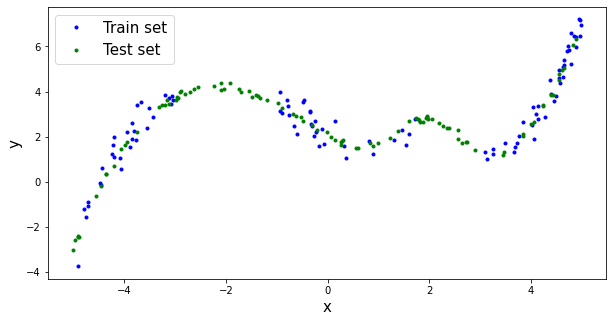

In [9]:
plt.figure(figsize=(10,5))

plt.plot(train_df.input , train_df.label,'bo' ,label = 'Train set',markersize=3)
plt.plot(test_df.input , test_df.label,'go' ,label = 'Test set',markersize=3)
plt.xlabel('x',fontsize=15)
plt.ylabel('y',fontsize=15)
plt.legend(fontsize=15)

plt.savefig("img/train_test_reg.png", dpi = 300)

## FIRST REGRESSION

In [12]:
train_dataset = RegressionDataset(train_df, transform=ToTensor())
test_dataset = RegressionDataset(test_df, transform=ToTensor())

batch_size = 20
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#, num_workers=0)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False)#, num_workers=0)

In [13]:
params = {
    'Nh1' : 20,
    'Nh2' : 30,
    'Nh3' : 20,
    'lr'  : 1e-2,
    'optimizer': 'Adam',
    'weight': 10**(-3)
    }
net = Net(params)
epochs = 500
net.train(epochs, train_dataloader, test_dataloader)
print("DONE")
print("Test error = ", net.val_loss[-1])

Train loss:   0%|          | 0/500 [00:00<?, ?it/s]

DONE
Test error =  0.31713602


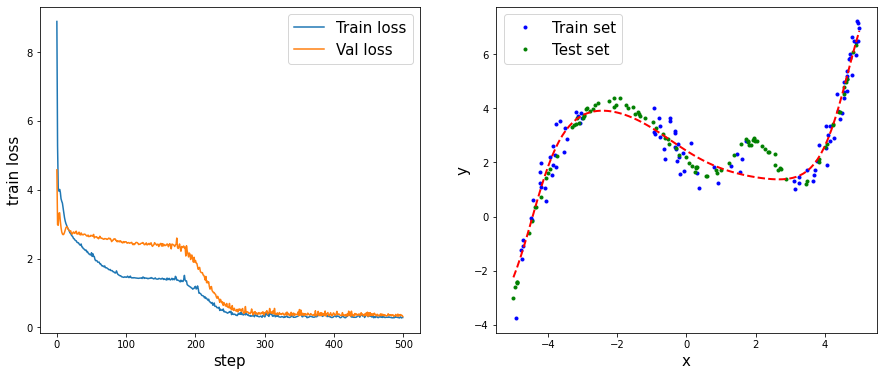

In [15]:
fig, ax = plt.subplots(1,2, figsize = (15,6))

x = torch.linspace(-5,5,100).unsqueeze(-1)
with torch.no_grad(): # turn off gradients computation
    y = net(x)
    
ax[0].plot(net.train_loss, label = 'Train loss')
ax[0].plot(net.val_loss, label = 'Val loss')
ax[0].set_xlabel('step',fontsize=15)
ax[0].set_ylabel('train loss',fontsize=15)
ax[0].legend(fontsize=15)

ax[1].plot(train_df.input , train_df.label,'bo' ,label = 'Train set',markersize=3)
ax[1].plot(test_df.input , test_df.label,'go' ,label = 'Test set',markersize=3)
ax[1].set_xlabel('x',fontsize=15)
ax[1].set_ylabel('y',fontsize=15)
ax[1].legend(fontsize=15)
ax[1].plot(x,y,'--',linewidth = 2,color='red')

## HYPERPARAMETER TUNING

In [16]:
torch.manual_seed(2012098)  

def objective(trial):
    # Parameters
    params = {
    'Nh1' : trial.suggest_int('Nh1', 10,50),
    'Nh2' : trial.suggest_int('Nh2', 10,50),
    'Nh3' : trial.suggest_int('Nh3', 3,30),
    'lr'  : trial.suggest_loguniform('lr', 1e-3, 1e-1),
    'weight'  : trial.suggest_loguniform('weight', 1e-4, 1e-1),
    'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    }
    epochs = 300
    val_loss = KTrain(params, epochs, train_df, 3)
    
    return np.mean(val_loss)

pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()

study = optuna.create_study(study_name="myfirstoptimizationstudy", direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=30)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-01 15:10:31,175] A new study created in memory with name: myfirstoptimizationstudy


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:10:49,023] Trial 0 finished with value: 0.3989424705505371 and parameters: {'Nh1': 36, 'Nh2': 18, 'Nh3': 17, 'lr': 0.01328186766193806, 'weight': 0.0010905904339082071, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:11:04,663] Trial 1 finished with value: 2.3925721645355225 and parameters: {'Nh1': 47, 'Nh2': 38, 'Nh3': 13, 'lr': 0.05357208867923235, 'weight': 0.017448181009982165, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:11:20,191] Trial 2 finished with value: 2.899873733520508 and parameters: {'Nh1': 17, 'Nh2': 39, 'Nh3': 23, 'lr': 0.05009033761173758, 'weight': 0.0014962402538864356, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:11:36,692] Trial 3 finished with value: 2.5586512088775635 and parameters: {'Nh1': 22, 'Nh2': 49, 'Nh3': 7, 'lr': 0.005148155616340465, 'weight': 0.025565622514597437, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:11:54,445] Trial 4 finished with value: 1.148647665977478 and parameters: {'Nh1': 24, 'Nh2': 25, 'Nh3': 12, 'lr': 0.020031897977395026, 'weight': 0.002148968342890465, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:12:09,972] Trial 5 finished with value: 2.814887285232544 and parameters: {'Nh1': 34, 'Nh2': 48, 'Nh3': 30, 'lr': 0.004835903717502857, 'weight': 0.019321950701746016, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:12:24,480] Trial 6 finished with value: 3.830225706100464 and parameters: {'Nh1': 24, 'Nh2': 22, 'Nh3': 30, 'lr': 0.0020844165874210566, 'weight': 0.040007934016138384, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:12:39,250] Trial 7 finished with value: 2.7137622833251953 and parameters: {'Nh1': 49, 'Nh2': 37, 'Nh3': 11, 'lr': 0.03675464590431179, 'weight': 0.05872416606256845, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:12:54,639] Trial 8 finished with value: 3.681696653366089 and parameters: {'Nh1': 16, 'Nh2': 47, 'Nh3': 10, 'lr': 0.0029874655860254876, 'weight': 0.0024500504070297693, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:13:12,725] Trial 9 finished with value: 2.42329478263855 and parameters: {'Nh1': 46, 'Nh2': 32, 'Nh3': 5, 'lr': 0.0031781479491555862, 'weight': 0.003880053198285061, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:13:31,010] Trial 10 finished with value: 0.6148889064788818 and parameters: {'Nh1': 36, 'Nh2': 10, 'Nh3': 19, 'lr': 0.011955273106986311, 'weight': 0.00010753758746160071, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:13:48,303] Trial 11 finished with value: 0.9367710947990417 and parameters: {'Nh1': 36, 'Nh2': 10, 'Nh3': 20, 'lr': 0.011843012351341262, 'weight': 0.00010292728678647684, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:14:05,119] Trial 12 finished with value: 0.6145352721214294 and parameters: {'Nh1': 39, 'Nh2': 11, 'Nh3': 18, 'lr': 0.013141134277259242, 'weight': 0.00019962033165739338, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:14:21,798] Trial 13 finished with value: 0.4469012916088104 and parameters: {'Nh1': 41, 'Nh2': 17, 'Nh3': 24, 'lr': 0.022114093194128513, 'weight': 0.0004637411659285393, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:14:38,336] Trial 14 finished with value: 0.7458493709564209 and parameters: {'Nh1': 43, 'Nh2': 18, 'Nh3': 25, 'lr': 0.027884330940842982, 'weight': 0.0005331331383768383, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:14:54,871] Trial 15 finished with value: 1.5994383096694946 and parameters: {'Nh1': 29, 'Nh2': 17, 'Nh3': 15, 'lr': 0.08169616521801129, 'weight': 0.000531847644182985, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:15:11,308] Trial 16 finished with value: 0.5301963686943054 and parameters: {'Nh1': 41, 'Nh2': 17, 'Nh3': 25, 'lr': 0.006740104158454669, 'weight': 0.0006161734281872412, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:15:26,864] Trial 17 finished with value: 3.051633834838867 and parameters: {'Nh1': 31, 'Nh2': 25, 'Nh3': 23, 'lr': 0.001193769242821987, 'weight': 0.0063830979699984565, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:15:43,441] Trial 18 finished with value: 0.7516983151435852 and parameters: {'Nh1': 10, 'Nh2': 29, 'Nh3': 27, 'lr': 0.020754008598832165, 'weight': 0.0010486016844406937, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:16:00,182] Trial 19 finished with value: 0.9851908087730408 and parameters: {'Nh1': 28, 'Nh2': 15, 'Nh3': 16, 'lr': 0.008367969207436918, 'weight': 0.00023729932699153076, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:16:16,036] Trial 20 finished with value: 1.9550689458847046 and parameters: {'Nh1': 42, 'Nh2': 22, 'Nh3': 21, 'lr': 0.020047087977993247, 'weight': 0.00742726253599854, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:16:39,011] Trial 21 finished with value: 0.910797655582428 and parameters: {'Nh1': 41, 'Nh2': 15, 'Nh3': 27, 'lr': 0.00702246939840361, 'weight': 0.0006488223113233499, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.3989424705505371.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:16:58,616] Trial 22 finished with value: 0.3094717562198639 and parameters: {'Nh1': 45, 'Nh2': 21, 'Nh3': 23, 'lr': 0.015776649838954087, 'weight': 0.0002980264262007086, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.3094717562198639.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:17:15,511] Trial 23 finished with value: 0.4102334976196289 and parameters: {'Nh1': 44, 'Nh2': 22, 'Nh3': 22, 'lr': 0.01565135441442982, 'weight': 0.00029009129582180024, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.3094717562198639.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:17:33,627] Trial 24 finished with value: 0.34760424494743347 and parameters: {'Nh1': 46, 'Nh2': 22, 'Nh3': 21, 'lr': 0.0125352472758329, 'weight': 0.0002560456859064033, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.3094717562198639.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:17:51,444] Trial 25 finished with value: 0.5931540131568909 and parameters: {'Nh1': 50, 'Nh2': 28, 'Nh3': 17, 'lr': 0.03178569049545405, 'weight': 0.0010819353458446407, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.3094717562198639.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:18:08,331] Trial 26 finished with value: 0.4466918408870697 and parameters: {'Nh1': 37, 'Nh2': 33, 'Nh3': 15, 'lr': 0.008958854779866247, 'weight': 0.0001775701749361721, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.3094717562198639.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:18:25,070] Trial 27 finished with value: 0.34540876746177673 and parameters: {'Nh1': 33, 'Nh2': 20, 'Nh3': 20, 'lr': 0.014641040397465365, 'weight': 0.00028955407217578453, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.3094717562198639.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:18:41,839] Trial 28 finished with value: 0.8287903666496277 and parameters: {'Nh1': 46, 'Nh2': 26, 'Nh3': 20, 'lr': 0.00518754595027506, 'weight': 0.0003141541871948037, 'optimizer': 'Adam'}. Best is trial 22 with value: 0.3094717562198639.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

[I 2022-07-01 15:18:57,858] Trial 29 finished with value: 1.5128530263900757 and parameters: {'Nh1': 33, 'Nh2': 21, 'Nh3': 27, 'lr': 0.01528602870927237, 'weight': 0.00013476881861388925, 'optimizer': 'RMSprop'}. Best is trial 22 with value: 0.3094717562198639.


Number of finished trials: 30
Best trial:
  Value: 0.3094717562198639
  Params: 
    Nh1: 45
    Nh2: 21
    Nh3: 23
    lr: 0.015776649838954087
    weight: 0.0002980264262007086
    optimizer: Adam


## BEST MODEL 

In [13]:
#torch.manual_seed(22223)  
torch.manual_seed(223)  

#params = trial.params
params = {'Nh1': 45, 'Nh2': 21, 'Nh3': 23, 'lr': 0.015776649838954087, 'weight': 0.0002980264262007086, 'optimizer': 'Adam'}
print(params)
epochs = 300

net = Net(params)
net.train(epochs, train_dataloader, test_dataloader)
print("DONE")
print("Test error = ", net.val_loss[-1])

{'Nh1': 45, 'Nh2': 21, 'Nh3': 23, 'lr': 0.015776649838954087, 'weight': 0.0002980264262007086, 'optimizer': 'Adam'}


Train loss:   0%|          | 0/300 [00:00<?, ?it/s]

DONE
Test error =  0.2691499


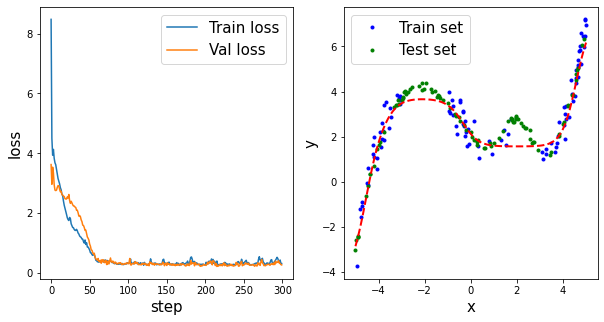

In [31]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

x = torch.linspace(-5,5,100).unsqueeze(-1)
with torch.no_grad(): # turn off gradients computation
    y = net(x)
    
ax[0].plot(net.train_loss, label = 'Train loss')
ax[0].plot(net.val_loss, label = 'Val loss')
ax[0].set_xlabel('step',fontsize=15)
ax[0].set_ylabel('loss',fontsize=15)
ax[0].legend(fontsize=15)


ax[1].plot(train_df.input , train_df.label,'bo' ,label = 'Train set',markersize=3)
ax[1].plot(test_df.input , test_df.label,'go' ,label = 'Test set',markersize=3)
ax[1].set_xlabel('x',fontsize=15)
ax[1].set_ylabel('y',fontsize=15)
ax[1].legend(fontsize=15)
ax[1].plot(x,y,'--',linewidth = 2,color='red')

plt.savefig("img/best_reg.png", dpi = 300)

## WEIGHT HISTOGRAMS

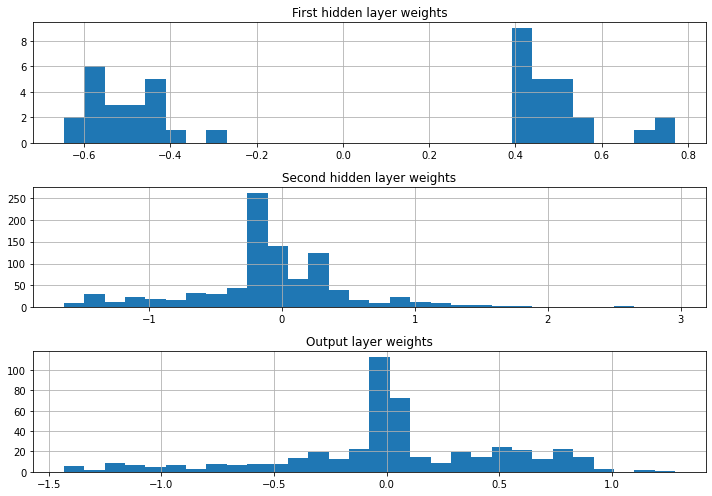

In [33]:
# First hidden layer
h1_w = net.net[0].weight.data.cpu().numpy()
h1_b = net.net[0].bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.net[2].weight.data.cpu().numpy()
h2_b = net.net[2].bias.data.cpu().numpy()

# Output layer
h3_w = net.net[4].weight.data.cpu().numpy()
h3_b = net.net[4].bias.data.cpu().numpy()

# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(10,7))
axs[0].hist(h1_w.flatten(), 30)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 30)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(h3_w.flatten(), 30)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.savefig("img/best_reg_weights.png", dpi = 200)


## ACTIVATION PROFILES

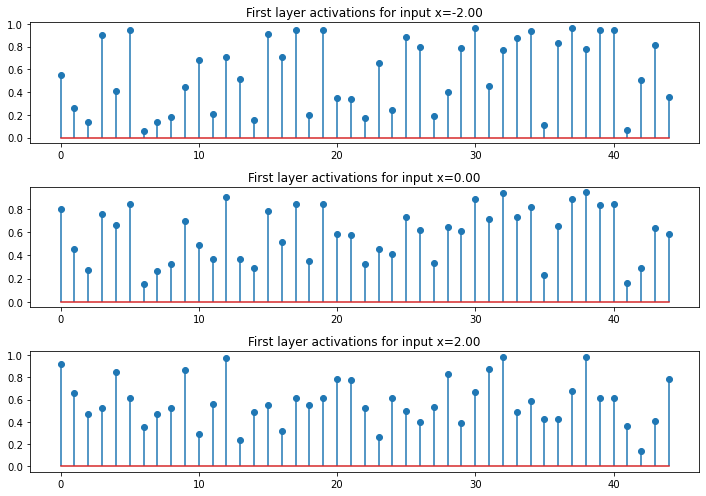

In [34]:
# First naive way: simply change the network definition to return an additional output

# More advanced strategy: using hooks

def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = net.net[0].register_forward_hook(get_activation)

### Analyze activations

#net.eval()
with torch.no_grad():
    x1 = torch.tensor([-2.]).float()
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.]).float()
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2]).float()
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(10,7))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('First layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('First layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('First layer activations for input x=%.2f' % x3)
plt.tight_layout()

plt.savefig("img/best_reg_act_1.png", dpi = 300)


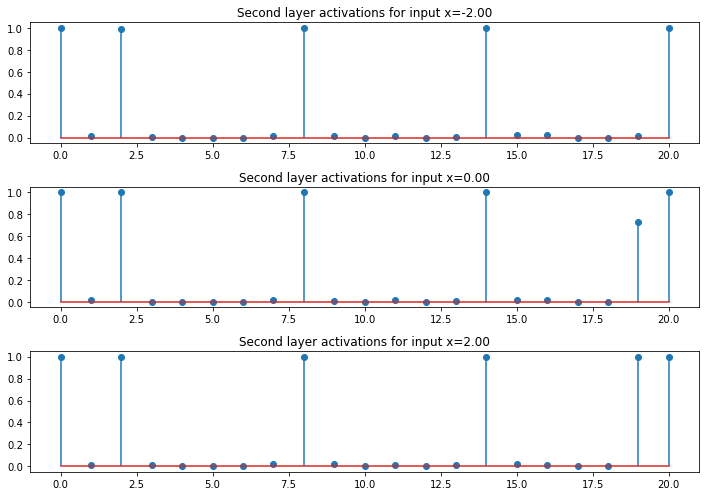

In [35]:
# First naive way: simply change the network definition to return an additional output

# More advanced strategy: using hooks

def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = net.net[2].register_forward_hook(get_activation)

### Analyze activations

#net.eval()
with torch.no_grad():
    x1 = torch.tensor([-2]).float()
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.]).float()
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2.]).float()
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(10,7))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Second layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Second layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Second layer activations for input x=%.2f' % x3)
plt.tight_layout()

plt.savefig("img/best_reg_act_2.png", dpi = 300)


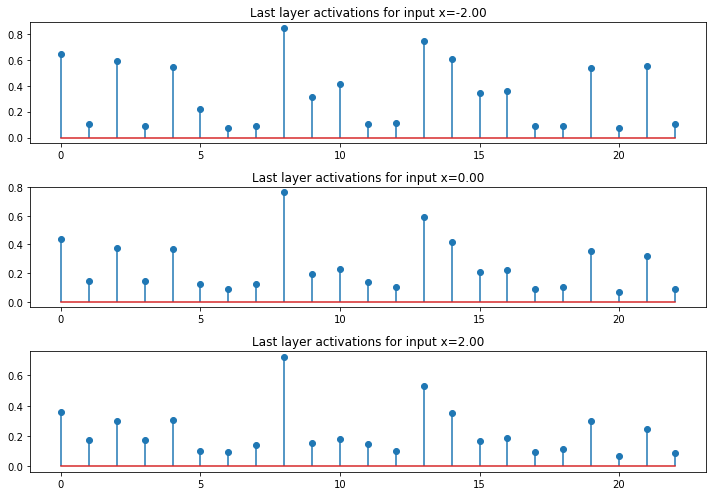

In [36]:
# First naive way: simply change the network definition to return an additional output

# More advanced strategy: using hooks

def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = net.net[4].register_forward_hook(get_activation)

### Analyze activations

#net.eval()
with torch.no_grad():
    x1 = torch.tensor([-2]).float()
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.]).float()
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2.]).float()
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(10,7))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()

plt.savefig("img/best_reg_act_3.png", dpi = 300)
